In [2]:
import os
import s3fs 

import numpy as np
import xarray as xr
import pandas as pd 
import cartopy.crs as ccrs
import ipywidgets as widgets
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import cartopy.feature as cfeature
import matplotlib.patheffects as path_effects


In [3]:
# load in methods for reading, writing, and managing files stored in S3. The connection is made anonamously. 
s3 = s3fs.S3FileSystem(anon=True) 
# List all data folders available from UNSW
s3_bucket_name = "imos-data/"
s3_org_name = "UNSW/"
s3_product = "NRS_extremes/Temperature_DataProducts_v2"
data_folders = s3.ls(f"{s3_bucket_name}{s3_org_name}{s3_product}")
# List all subfolders under the product directory
data_folders

['imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/PH050',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/PH100',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/ROT055']

## Load datasets into Memory (explicit load)

In [4]:
# Initialize an empty dictionary to store datasets
datasets = {}

# Iterate through each subfolder and load .nc files
for folder in data_folders:
    # List files in the current folder
    files_in_folder = s3.ls(folder)
    
    # Filter for .nc files
    nc_files = [file for file in files_in_folder if file.endswith(".nc")]
    
    # Load each .nc file into memory
    for nc_file in nc_files:
        # Open the file using s3fs and load the dataset into memory with xarray
        with s3.open(nc_file, mode='rb') as f:
            ds = xr.open_dataset(f, engine="h5netcdf")
            ds.load()  # Explicitly load the dataset into memory
        
        # Add to the datasets dictionary using the folder name as the key
        datasets[folder] = ds

In [13]:
datasets

{'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090': <xarray.Dataset> Size: 8MB
 Dimensions:                                 (TIME: 29176, DEPTH: 2)
 Coordinates:
   * TIME                                    (TIME) datetime64[ns] 233kB 1944-...
   * DEPTH                                   (DEPTH) float32 8B 2.0 21.0
 Data variables: (12/35)
     TEMP                                    (TIME, DEPTH) float32 233kB nan ....
     TEMP_INTERP                             (TIME, DEPTH) float32 233kB nan ....
     TEMP_HEAT_SPIKE                         (TIME, DEPTH) float32 233kB nan ....
     TEMP_COLD_SPIKE                         (TIME, DEPTH) float32 233kB nan ....
     TEMP_EXTREME_INDEX                      (TIME, DEPTH) float32 233kB nan ....
     TEMP_PER10                              (TIME, DEPTH) float32 233kB 14.37...
     ...                                      ...
     MCS_EVENT_INTENSITY_VAR                 (TIME, DEPTH) float32 233kB nan ....
     MCS_EVENT_INTE

##  Show location of stations in the Climatology directory

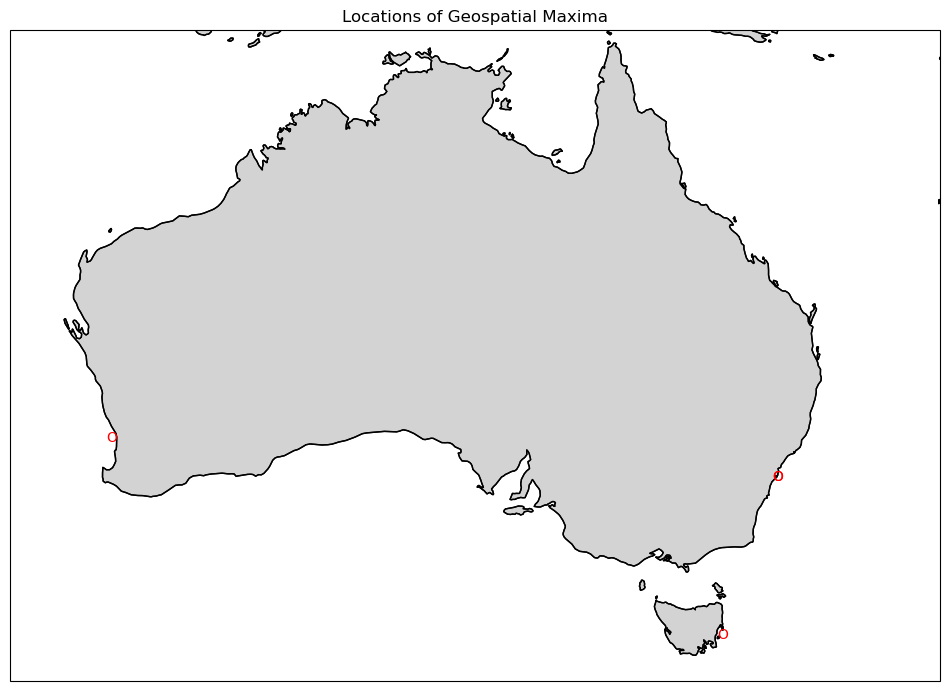

In [14]:
# Create a figure and a map with coastlines
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and land features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Set the extent to focus on Australia (bounding box coordinates)
ax.set_extent([110, 160, -45, -10], crs=ccrs.PlateCarree())  # [lon_min, lon_max, lat_min, lat_max]


# Iterate over datasets to plot the "O" at coordinates of the mooring
    lat = ds.attrs.get('geospatial_lat_max')
    lon = ds.attrs.get('geospatial_lon_max')
    
    # Check if the attributes exist before plotting
    if lat is not None and lon is not None:
        ax.text(lon, lat, 'O', fontsize=10, color='red', ha='center', va='center',
                transform=ccrs.PlateCarree())

# Set title and show plot
ax.set_title('Locations of Geospatial Maxima')
plt.show()

## Create and interactive date picker with the colour coded spikes

In [5]:
# Function to convert date to "days since 1950-01-01"
def date_to_days_since_1950(date):
    ref_date = pd.to_datetime("1950-01-01")
    delta = date - ref_date
    return delta.days

# Function to update the plot
def update_plot(date):
    # Convert selected date to "days since 1950-01-01"
    target_days = date_to_days_since_1950(pd.to_datetime(date))
    
    # Create a figure and a map with coastlines
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
    ax.set_extent([110, 160, -45, -10], crs=ccrs.PlateCarree())

    # Iterate over datasets to plot markers
    for folder, ds in datasets.items():
        lat = ds.attrs.get('geospatial_lat_max')
        lon = ds.attrs.get('geospatial_lon_max')
        
        if lat is not None and lon is not None:
            # TIME is already in datetime64 format, so no need for timedelta conversion
            time_in_days = (ds['TIME'].values - np.datetime64("1950-01-01")) / np.timedelta64(1, 'D')

            # Find the index for the selected date in days since 1950
            date_idx = np.isclose(time_in_days, target_days, atol=0.5)  # use a tolerance for floating point comparisons
            
            if date_idx.any():
                temp_heat_spike = ds['TEMP_HEAT_SPIKE'].values[date_idx]
                temp_cold_spike = ds['TEMP_COLD_SPIKE'].values[date_idx]
                
                if not pd.isna(temp_heat_spike).all():
                    ax.plot(lon, lat, 'o', markersize=10, color='red', markeredgecolor='black', markeredgewidth=1.5,
                            transform=ccrs.PlateCarree())
                elif not pd.isna(temp_cold_spike).all():
                    ax.plot(lon, lat, 'o', markersize=10, color='blue', markeredgecolor='black', markeredgewidth=1.5,
                            transform=ccrs.PlateCarree())
                else:
                    ax.text(lon, lat, 'O', fontsize=15, color='black', ha='center', va='center',
                            transform=ccrs.PlateCarree())
    
    ax.set_title(f'Heat and Cold Spikes on {date}')
    plt.show()

# Create a date picker widget
date_picker = widgets.DatePicker(
    description='Select Date',
    value=pd.to_datetime("2018-11-30") # Date happens to be a Heatwave and a Cold spike at the same time east and west.
)

# Create an interactive function to trigger the plot update when the date changes
widgets.interactive(update_plot, date=date_picker)



interactive(children=(DatePicker(value=Timestamp('2018-11-30 00:00:00'), description='Select Date', step=1), O…